Found 1030 images belonging to 4 classes.
33/33 [==============================] - 73s 2s/step
Model Accuracy: 0.8757281553398059
Precision: 0.8807208642234778
Recall: 0.8757281553398059
F1 Score: 0.8722913760023444
AUC: 1.0
1/1 [==============================] - 3s 3s/step
Average Inference Time per Image (for 200 photos): 2.491940084695816 seconds
Model Size (KB): 301568.03125
Average Specificity: 0.9600753856073004
Matthews Correlation Coefficient: 0.816753708219872


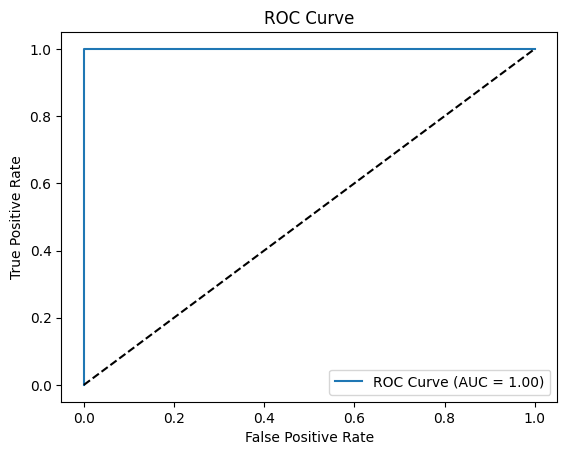

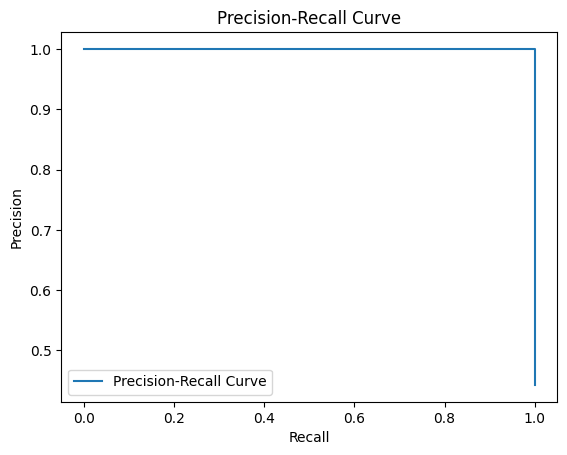

F2 Score (Beta = 2): 0.8730910937656859
Inference Speed (FPS): 0.4012937574789512
Model Complexity (Trainable Parameters): 25636868
Calibration Probabilities (True):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9193548387096774]
Calibration Probabilities (Predicted):  [7.576908872831e-05, 0.16289737820625305, 0.2540871091187, 0.3573032021522522, 0.4349099606275558, 0.5623120218515396, 0.6488732099533081, 0.7456206917762757, 0.872426763176918, 0.9972889788689152]


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
from sklearn.calibration import calibration_curve  # Import calibration_curve
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the pre-trained MobileNetV3Large model
model = tf.keras.models.load_model('d:\Capstone\koi bhi\Top_5_Models\pose_classification_model_resnet50.h5')

# Test data directory
TEST_DIR = r"d:\Capstone\koi bhi\test"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming your data has binary or multi-class format
# For binary classification, you can use a one-hot encoding of the labels and calculate the AUC for each class separately.
# For multi-class classification, use 'roc_auc_ovo' for One-vs-One AUC or 'roc_auc_ovr' for One-vs-Rest AUC.
# Here, we will assume binary classification for simplicity.
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('d:\Capstone\koi bhi\Top_5_Models\pose_classification_model_resnet50.h5') / 1024.0
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])
    
    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)

# 13. Inference Speed (Frames Per Second, FPS)
# Assuming each image takes 'average_inference_time' seconds for inference
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)






Found 1030 images belonging to 4 classes.
33/33 [==============================] - 11s 287ms/step
Model Accuracy: 0.44271844660194176
Precision: 0.19599962296163634
Recall: 0.44271844660194176
F1 Score: 0.2717087639979615
AUC: 0.8588009658292072


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 283ms/step
Average Inference Time per Image (for 200 photos): 0.32596718192100527 seconds
Model Size (KB): 32275.484375
Average Specificity: 0.8142394822006472
Matthews Correlation Coefficient: 0.0


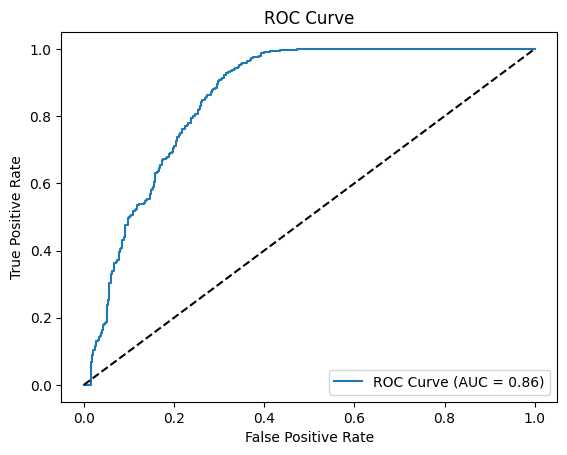

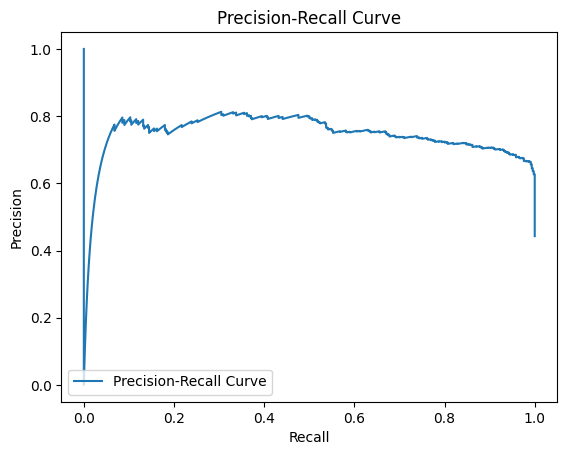

F2 Score (Beta = 2): 0.3536783665916002
Inference Speed (FPS): 3.067793494138743
Model Complexity (Trainable Parameters): 1683556
Calibration Probabilities (True):  [0.44271844660194176]
Calibration Probabilities (Predicted):  [0.4331144099675336]


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
from sklearn.calibration import calibration_curve  # Import calibration_curve
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the pre-trained MobileNetV3Large model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_MobileNetV3Large.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming your data has binary or multi-class format
# For binary classification, you can use a one-hot encoding of the labels and calculate the AUC for each class separately.
# For multi-class classification, use 'roc_auc_ovo' for One-vs-One AUC or 'roc_auc_ovr' for One-vs-Rest AUC.
# Here, we will assume binary classification for simplicity.
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_MobileNetV3Large.h5') / 1024.0
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])
    
    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)



# 13. Inference Speed (Frames Per Second, FPS)
# Assuming each image takes 'average_inference_time' seconds for inference
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 20. Confidence Calibration
prob_true, prob_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True): ", prob_true.tolist())
print("Calibration Probabilities (Predicted): ",prob_pred.tolist())





#MobileNetV2

Found 1030 images belonging to 4 classes.
33/33 [==============================] - 9s 263ms/step
Model Accuracy: 0.845631067961165
Precision: 0.8453475052111699
Recall: 0.845631067961165
F1 Score: 0.8268216762454464
AUC: 0.9999617947307293


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 267ms/step
Average Inference Time per Image (for 200 photos): 0.3011083495616913 seconds
Model Size (KB): 32917.1640625
Average Specificity: 0.9551173291108312
Matthews Correlation Coefficient: 0.7877307675518334


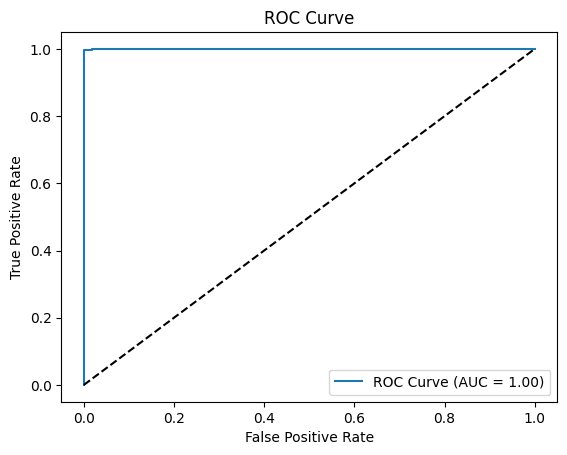

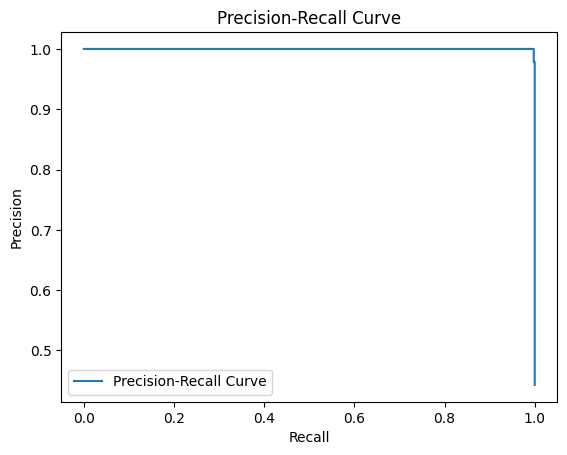

F2 Score (Beta = 2): 0.8331285084591039
Inference Speed (FPS): 3.3210636684623696
Model Complexity (Trainable Parameters): 2011236
Calibration Probabilities (True):  [0.         0.         0.         0.16666667 0.         0.
 1.         1.         1.         1.        ]
Calibration Probabilities (Predicted):  [0.02995508 0.12297922 0.24803375 0.34327023 0.42660237 0.52922308
 0.65337098 0.76261566 0.87740672 0.99703087]


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
from sklearn.calibration import calibration_curve
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the pre-trained MobileNetV2 model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_MobileNetV2.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming your data has binary or multi-class format
# For binary classification, you can use a one-hot encoding of the labels and calculate the AUC for each class separately.
# For multi-class classification, use 'roc_auc_ovo' for One-vs-One AUC or 'roc_auc_ovr' for One-vs-Rest AUC.
# Here, we will assume binary classification for simplicity.
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_MobileNetV2.h5') / 1024.0
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])
    
    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)



# 13. Inference Speed (Frames Per Second, FPS)
# Assuming each image takes 'average_inference_time' seconds for inference
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 20. Confidence Calibration
prob_true, prob_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True): ", prob_true)
print("Calibration Probabilities (Predicted): ", prob_pred)


Found 1030 images belonging to 4 classes.
33/33 [==============================] - 7s 161ms/step
Model Accuracy: 0.44271844660194176
Precision: 0.19599962296163634
Recall: 0.44271844660194176
F1 Score: 0.2717087639979615
AUC: 0.5


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 157ms/step
Average Inference Time per Image (for 200 photos): 0.18834417104721068 seconds
Model Size (KB): 19500.40625
Average Specificity: 0.8142394822006472
Matthews Correlation Coefficient: 0.0


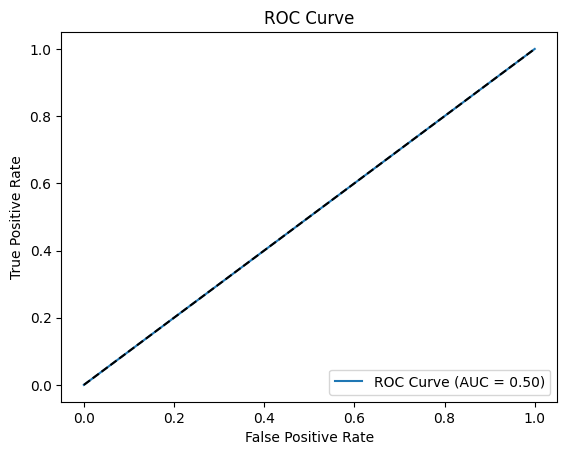

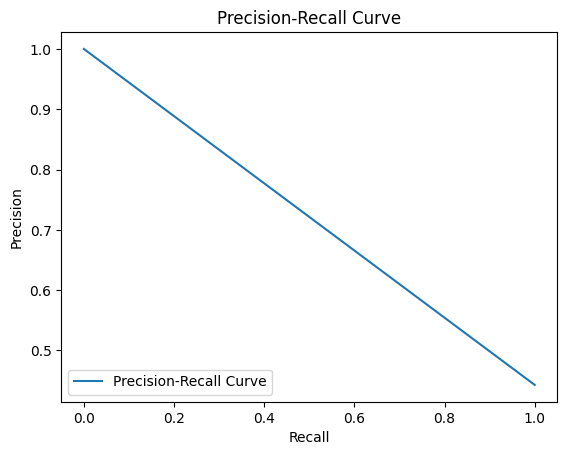

F2 Score (Beta = 2): 0.3536783665916002
Inference Speed (FPS): 5.309428980147935
Model Complexity (Trainable Parameters): 1290340
Calibration Probabilities (True):  [0.44271844660194176]
Calibration Probabilities (Predicted):  [0.4444073438644409]


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
from sklearn.calibration import calibration_curve  # Import calibration_curve
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the pre-trained MobileNetV3Large model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_MobileNetV3Small.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming your data has binary or multi-class format
# For binary classification, you can use a one-hot encoding of the labels and calculate the AUC for each class separately.
# For multi-class classification, use 'roc_auc_ovo' for One-vs-One AUC or 'roc_auc_ovr' for One-vs-Rest AUC.
# Here, we will assume binary classification for simplicity.
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_MobileNetV3Small.h5') / 1024.0
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])
    
    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)



# 13. Inference Speed (Frames Per Second, FPS)
# Assuming each image takes 'average_inference_time' seconds for inference
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 20. Confidence Calibration
prob_true, prob_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True): ", prob_true.tolist())
print("Calibration Probabilities (Predicted): ",prob_pred.tolist())





Found 1030 images belonging to 4 classes.
33/33 [==============================] - 10s 275ms/step
Model Accuracy: 0.9242718446601942
Precision: 0.9433876896974267
Recall: 0.9242718446601942
F1 Score: 0.9237137573475992
AUC: 1.0
1/1 [==============================] - 0s 208ms/step
Average Inference Time per Image (for 200 photos): 0.24175668716430665 seconds
Model Size (KB): 24693.3671875
Average Specificity: 0.9763349514563107
Matthews Correlation Coefficient: 0.8959327994413083


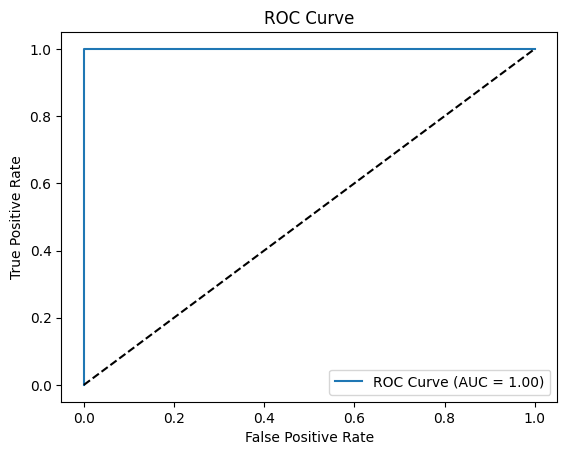

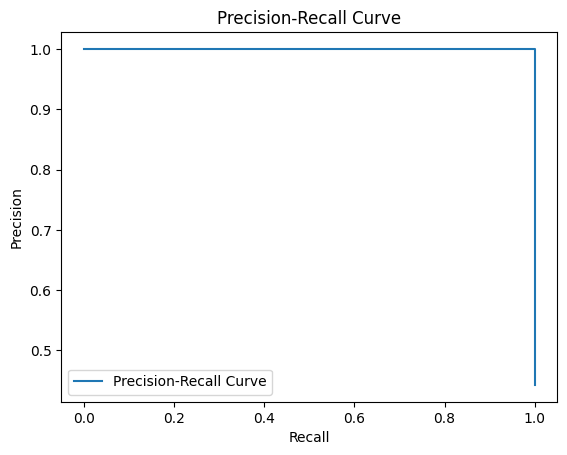

F2 Score (Beta = 2): 0.9217087725053259
Inference Speed (FPS): 4.136390234866031
Model Complexity (Trainable Parameters): 2096644
Calibration Probabilities (True):  [0.0, 1.0]
Calibration Probabilities (Predicted):  [0.0001263933559788761, 0.9999633641880855]


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
from sklearn.calibration import calibration_curve  # Import calibration_curve
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the pre-trained MobileNetV3Large model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_CNN.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming your data has binary or multi-class format
# For binary classification, you can use a one-hot encoding of the labels and calculate the AUC for each class separately.
# For multi-class classification, use 'roc_auc_ovo' for One-vs-One AUC or 'roc_auc_ovr' for One-vs-Rest AUC.
# Here, we will assume binary classification for simplicity.
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_CNN.h5') / 1024.0
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])
    
    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)



# 13. Inference Speed (Frames Per Second, FPS)
# Assuming each image takes 'average_inference_time' seconds for inference
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 20. Confidence Calibration
prob_true, prob_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True): ", prob_true.tolist())
print("Calibration Probabilities (Predicted): ",prob_pred.tolist())





In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
from sklearn.calibration import calibration_curve  # Import calibration_curve
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the pre-trained MobileNetV3Large model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_DenseNet121.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)
# 1. Model Accuracy
y_true = test_generator.classes
y_pred
_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming your data has binary or multi-class format
# For binary classification, you can use a one-hot encoding of the labels and calculate the AUC for each class separately.
# For multi-class classification, use 'roc_auc_ovo' for One-vs-One AUC or 'roc_auc_ovr' for One-vs-Rest AUC.
# Here, we will assume binary classification for simplicity.
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_DenseNet121.h5')
model_size_kb
# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])
    
    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)



# 13. Inference Speed (Frames Per Second, FPS)
# Assuming each image takes 'average_inference_time' seconds for inference
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 20. Confidence Calibration
prob_true, prob_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True): ", prob_true.tolist())
print("Calibration Probabilities (Predicted): ",prob_pred.tolist())





Found 1030 images belonging to 4 classes.


50376768

InceptionV3

Found 1030 images belonging to 4 classes.
33/33 [==============================] - 14s 394ms/step
Model Accuracy: 0.7165048543689321
Precision: 0.7751681067040032
Recall: 0.7165048543689321
F1 Score: 0.6243012598955759
AUC: 0.9998089736536462


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 492ms/step
Average Inference Time per Image (for 200 photos): 0.48804842710494994 seconds
Model Size (KB): 121712920
Average Specificity: 0.9264654926499238
Matthews Correlation Coefficient: 0.6173196884418186


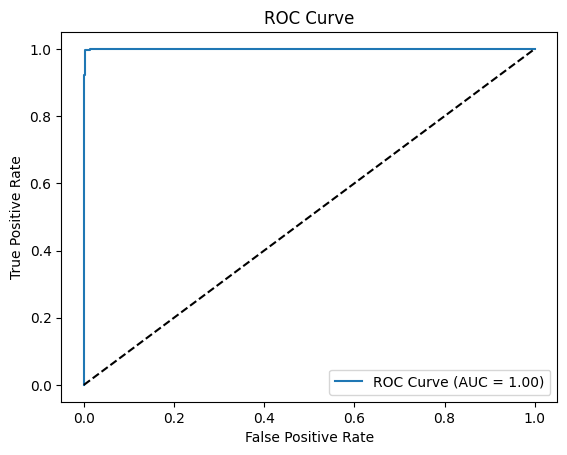

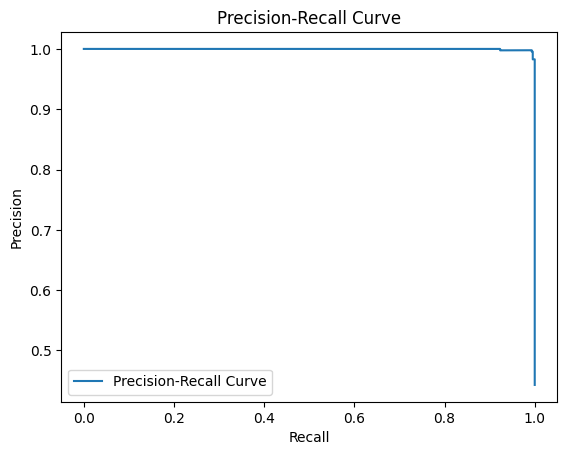

F2 Score (Beta = 2): 0.6714939204593454
Inference Speed (FPS): 2.048976995852422
Model Complexity (Trainable Parameters): 2797668
Calibration Probabilities (True): [0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.4, 1.0, 0.9655172413793104, 1.0]
Calibration Probabilities (Predicted): [0.06570097275524057, 0.15232169926166533, 0.24982229337610048, 0.3426364881021005, 0.44350091020266214, 0.5314330607652664, 0.6396855711936951, 0.755115882916884, 0.856031713814571, 0.9880724902880393]


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Load the pre-trained model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_InceptionV3.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming binary classification for simplicity
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_InceptionV3.h5')
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])

    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)

# 13. Inference Speed (Frames Per Second, FPS)
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 15. Calibration Probabilities
# Assuming binary classification for simplicity
calibration_true, calibration_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True):", calibration_true.tolist())
print("Calibration Probabilities (Predicted):", calibration_pred.tolist())



Resnet50

Found 1030 images belonging to 4 classes.
33/33 [==============================] - 36s 1s/step
Model Accuracy: 0.44271844660194176
Precision: 0.19599962296163634
Recall: 0.44271844660194176
F1 Score: 0.2717087639979615
AUC: 0.5


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step
Average Inference Time per Image (for 200 photos): 1.0720941615104675 seconds
Model Size (KB): 128510304
Average Specificity: 0.8142394822006472
Matthews Correlation Coefficient: 0.0


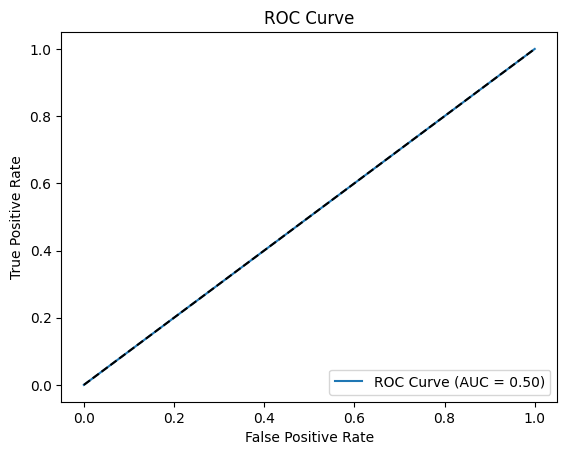

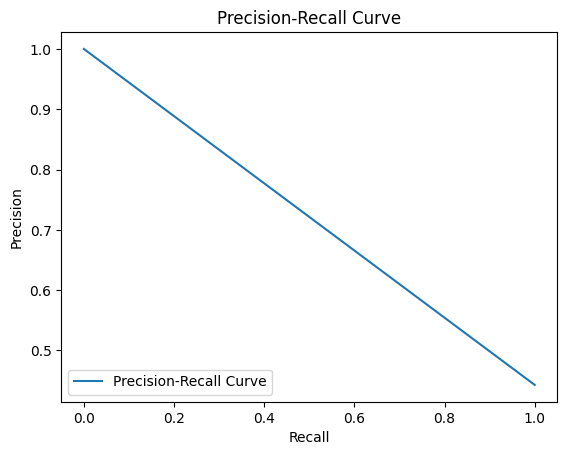

F2 Score (Beta = 2): 0.3536783665916002
Inference Speed (FPS): 0.9327538903776004
Model Complexity (Trainable Parameters): 2797668
Calibration Probabilities (True): [0.44271844660194176]
Calibration Probabilities (Predicted): [0.4377197325229645]


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Load the pre-trained model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_ResNet50.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming binary classification for simplicity
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_ResNet50.h5')
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])

    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)

# 13. Inference Speed (Frames Per Second, FPS)
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 15. Calibration Probabilities
# Assuming binary classification for simplicity
calibration_true, calibration_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True):", calibration_true.tolist())
print("Calibration Probabilities (Predicted):", calibration_pred.tolist())



VGG16

Found 1030 images belonging to 4 classes.
33/33 [==============================] - 73s 2s/step
Model Accuracy: 0.9262135922330097
Precision: 0.9389587239447823
Recall: 0.9262135922330097
F1 Score: 0.926154542120718
AUC: 1.0
1/1 [==============================] - 2s 2s/step
Average Inference Time per Image (for 200 photos): 2.202490360736847 seconds
Model Size (KB): 73692976
Average Specificity: 0.9762845504073574
Matthews Correlation Coefficient: 0.8959260675241743


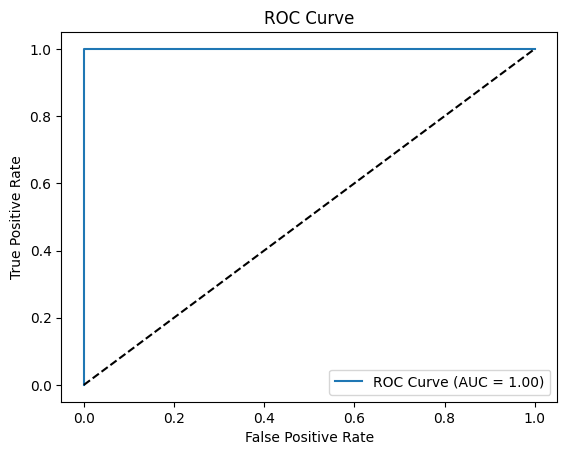

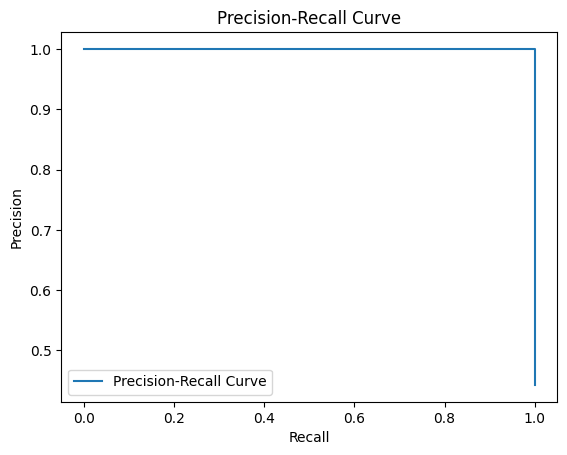

F2 Score (Beta = 2): 0.9247095184945378
Inference Speed (FPS): 0.4540314989916452
Model Complexity (Trainable Parameters): 1224804
Calibration Probabilities (True): [0.0, 0.0, 1.0]
Calibration Probabilities (Predicted): [0.0033702695650734767, 0.2448890507221222, 0.9999571802061901]


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Load the pre-trained model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_VGG16.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming binary classification for simplicity
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_VGG16.h5')
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])

    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)

# 13. Inference Speed (Frames Per Second, FPS)
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 15. Calibration Probabilities
# Assuming binary classification for simplicity
calibration_true, calibration_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True):", calibration_true.tolist())
print("Calibration Probabilities (Predicted):", calibration_pred.tolist())



Xception

Found 1030 images belonging to 4 classes.
33/33 [==============================] - 125s 4s/step
Model Accuracy: 0.9689320388349515
Precision: 0.9727121709919154
Recall: 0.9689320388349515
F1 Score: 0.9690108867634627
AUC: 1.0
1/1 [==============================] - 4s 4s/step
Average Inference Time per Image (for 200 photos): 3.8671437776088715 seconds
Model Size (KB): 117480152
Average Specificity: 0.9897172236503856
Matthews Correlation Coefficient: 0.9554056637562202


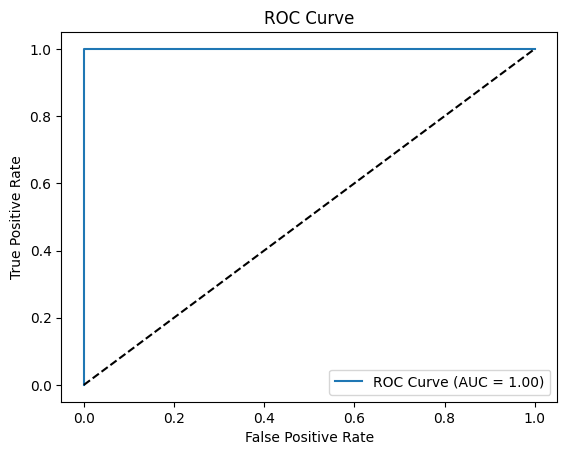

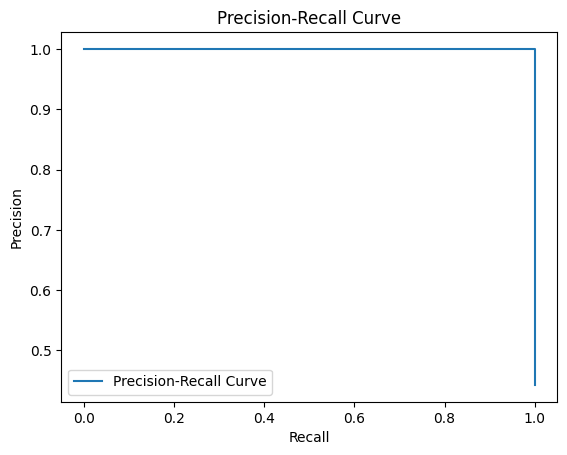

F2 Score (Beta = 2): 0.9685265379373229
Inference Speed (FPS): 0.25858878218857406
Model Complexity (Trainable Parameters): 2797668
Calibration Probabilities (True): [0.0, 1.0]
Calibration Probabilities (Predicted): [0.008874696301050776, 0.9999762390527809]


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    precision_recall_curve,
    fbeta_score,
)
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Load the pre-trained model
model = tf.keras.models.load_model('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_Xception.h5')

# Test data directory
TEST_DIR = r"C:/Users/Lenovo/Desktop/koi bhi/test/"

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent results
)

# 1. Model Accuracy
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Model Accuracy:", accuracy)

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# 4. F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

# 5. Area Under the ROC Curve (AUC)
# Assuming binary classification for simplicity
auc_value = roc_auc_score(y_true == 0, y_pred_prob[:, 0])
print("AUC:", auc_value)

# 6. Average Inference Time per Image (for 200 photos)
num_images = 200
if num_images > len(test_generator.filenames):
    num_images = len(test_generator.filenames)

total_time = 0
for i in range(num_images):
    image, _ = next(test_generator)
    start_time = time.time()
    model.predict(image)
    end_time = time.time()
    total_time += end_time - start_time

average_inference_time = total_time / num_images
print("Average Inference Time per Image (for 200 photos):", average_inference_time, "seconds")

# 7. Model Size
model_size_kb = os.path.getsize('C:/Users/Lenovo/Desktop/koi bhi/Model/pose_classification_model_new_added_layer_Xception.h5')
print("Model Size (KB):", model_size_kb)

# 8. Specificity per class
conf_mat = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(conf_mat.shape[0]):
    tn = np.sum(np.delete(conf_mat, i, axis=0)[:, np.delete(np.arange(conf_mat.shape[0]), i)])
    fp = np.sum(conf_mat[i, np.delete(np.arange(conf_mat.shape[0]), i)])

    # Check if TN and FP are both non-zero to avoid division by zero
    if tn + fp > 0:
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

# Average specificity across classes
average_specificity = np.mean(specificity_per_class)
print("Average Specificity:", average_specificity)

# 9. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

# 10. Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_true == 0, y_pred_prob[:, 0])
roc_auc_value = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 11. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true == 0, y_pred_prob[:, 0])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# 12. F2 Score (Beta = 2, gives more weight to Recall)
f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)
print("F2 Score (Beta = 2):", f2)

# 13. Inference Speed (Frames Per Second, FPS)
fps = 1 / average_inference_time
print("Inference Speed (FPS):", fps)

# 14. Model Complexity (Number of Trainable Parameters)
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("Model Complexity (Trainable Parameters):", trainable_params)

# 15. Calibration Probabilities
# Assuming binary classification for simplicity
calibration_true, calibration_pred = calibration_curve(y_true == 0, y_pred_prob[:, 0], n_bins=10, strategy='uniform')
print("Calibration Probabilities (True):", calibration_true.tolist())
print("Calibration Probabilities (Predicted):", calibration_pred.tolist())



TOPSIS

In [14]:
import numpy as np
import pandas as pd

# Read data from the Excel sheet
data = pd.read_excel(r'C:\Users\Lenovo\Desktop\koi bhi\Topsis.xlsx')

# Extract the performance metric columns
performance_metrics = data.iloc[:, 1:].to_numpy()

# Define the weight vector and direction vector for each criterion
weights = np.array([0.2, 0.15, 0.15, 0.1, 0.1, 0.1, 0.05, 0.05, 0.1])
directions = np.array([1, 1, 1, 1, -1, 1, 1, 1, -1])

# Normalize the performance metrics
normalized_metrics = performance_metrics / np.linalg.norm(performance_metrics, axis=0)

# Calculate the ideal and anti-ideal solutions
ideal_solution = directions * np.max(normalized_metrics, axis=0)
anti_ideal_solution = directions * np.min(normalized_metrics, axis=0)

# Calculate the Euclidean distances to the ideal and anti-ideal solutions
distance_to_ideal = np.linalg.norm(normalized_metrics - ideal_solution, axis=1)
distance_to_anti_ideal = np.linalg.norm(normalized_metrics - anti_ideal_solution, axis=1)

# Calculate the TOPSIS score for each model
topsis_scores = distance_to_anti_ideal / (distance_to_ideal + distance_to_anti_ideal)

# Calculate the rank of each model
rank = np.argsort(topsis_scores) + 1  # Adding 1 to start ranks from 1

# Add TOPSIS results to the DataFrame
data['TOPSIS Score'] = topsis_scores
data['Rank'] = rank

# Save the updated DataFrame to the Excel sheet
data.to_excel(r'C:\Users\Lenovo\Desktop\koi bhi\topsis_results.xlsx', index=False)


TypeError: loop of ufunc does not support argument 96 of type str which has no callable conjugate method

In [29]:
!pip install 102003053

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for 102003053: filename=102003053-1.1.0-py3-none-any.whl size=3674 sha256=4d933c497dde880e83d16f025f35cdc14a34c1d8e5eacc2eb63a84914bc7a7f1
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\e4\83\ab\da6649d34799dee648474820fc0b62df1fb843dc78b7fd5f82
Successfully built 102003053
